In [1]:
!pip install einops
!pip install bottleneck
!pip install tslearn
%load_ext autoreload
%autoreload 2

import seaborn as sns
# from dataclasses import dataclass
from dataclasses import dataclass, field
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from hdst import HDST
import torch
import gc
import numpy as np

## Create Args Configuration Class

In [2]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = None

    run_name: str = ""
    batch_size: int = 128
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 20
    window_size: int = 10
    # window_size: str = "Auto"
    # window_size: list = field(default_factory=lambda: [20, 50, 100, 200, 400, 800])
    distance: str = "mcc"
    top_k: int =3 # Use the top k prominent periodicity as time scale. If use sepcified window size, you can set top_k as random number.
    tmp_emb_type: str = "original" # Define the embedding type of time stamps. 
        #'temporal_fixed': using FixedEmbedding with explicit timestamps inputs. Like ETT
        #'temporal_learn': using nn.Embedding with explicit timestamps inputs.
        #'positional': using PositionalEmbedding with synthetic timestamps inputs. Like UEA
        #'original' : using original input to extract dynamic information. 
    freq: str = 'h' # 'h' for 'ETTh1', 'ETTh2', 't' for 'ETTm1' and 'ETTm2'

## Instantiate Args Configuration Class
Create an instance of arguments, specifying the necessary arguments and those important to your use case.

In [3]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0.,
        'global_vatiant_contrast': 0.9,
        'dynamic_trend_pred': 0.1,
        'dynamic_trend_pred2': 0.,
    },
    eval=False,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# device="cpu"

## Load your data
Yahoo dataset should be preprocessed using `datasets/preprocess_yahoo.py` and placed at `datasets/yahoo.pkl`.

In [4]:
# !python datasets/preprocess_yahoo.py --path datasets/ydata-labeled-time-series-anomalies-v1_0
# !pip install tables
# !python datasets/preprocess_kpi.py --train-file datasets/KPI/phase2_train.csv --test-file datasets/KPI/phase2_ground_truth.hdf

Load yahoo dataset. You can use any data, as long as it is an `np.ndarray` of shape $(N, T, C)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.

In [5]:
all_train_data, all_train_labels, all_train_timestamps, all_test_data, all_test_labels, all_test_timestamps, delay = datautils.load_anomaly("kpi")
train_data = datautils.gen_ano_train_data(all_train_data)
n_channels=train_data.shape[2]
print(f"Shapes - train data: {train_data.shape}")
# print(all_train_timestamps)
print(n_channels)
# print(train_data)
# import pandas as pd

# df = pd.DataFrame(list(all_test_timestamps.items()), columns=["Key", "Value"])
# print(len(df["Value"]))
# print(len(df["Value"].iloc[0]))
# df.head()  # show first 5 rows


Shapes - train data: (58, 74580, 1)
1


In [6]:
from torch.utils.data import TensorDataset, DataLoader
from utils import FFT_for_Period
train_data_temp = (torch.from_numpy(train_data).to(torch.float))
scale_list, scale_weight = FFT_for_Period(train_data_temp, 5)
print(scale_list)

[24860, 18645, 74580, 14916, 37290]


## Create and Train the model

In [7]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

20

In [8]:
import time
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    tmp_embed_type=args.tmp_emb_type,
    freq=args.freq,
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size,
    distance=args.distance,
    top_k=args.top_k,
    n_channels=n_channels
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (3719, 802, 1)
Scale list: [10]


Training: 20it [07:04, 21.20s/it, epoch=20, loss=0.278]

Model training time: 426.19 seconds


Save model and loss log

In [9]:
# import torch
# # torch.save(model, 'logs/mymodel_yahoo.pth')
# import pandas as pd
# df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
# df.to_csv("logs/loss_log_yahoo.csv", index=False)

Visualize the loss curve and save figure

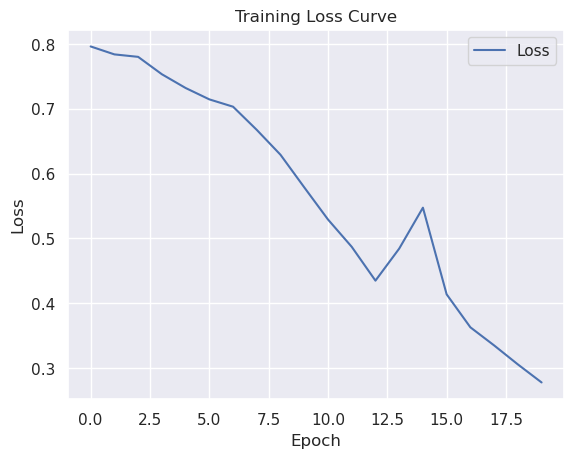

In [10]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss_log, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Test the model
Firstly, get the representation of training data and test data using `model.encode`. Then train a Ridge regression model using training representation and corresponding training labels. Finally, use the Ridge regression model to do forecasting for test representation. Report the MSE and MAE.

In [11]:
from tasks.anomaly_detection import eval_anomaly_detection
out, eval_res = eval_anomaly_detection(
                model,
                n_channels,
                all_train_data,
                all_train_labels,
                all_train_timestamps,
                all_test_data,
                all_test_labels,
                all_test_timestamps,
                delay, verbose=True
            )

Encoding representations with mask...
Encoding representations without mask...
Done
Computing anomalies
Done! Execution time: 2680.713316679001


In [12]:
eval_res

{'f1': 0.08905436800616827,
 'precision': 0.3083462132921175,
 'recall': 0.05204244975395743,
 'infer_time': 2680.713316679001}